In [14]:
import pandas as pd

df = pd.read_csv("first_large_2411.csv")
print(len(df))

11682


In [4]:
print(df.head())

                                         txt_content  \
0  How long do points stay on your licence?\nIf y...   
1  How long do points stay on your licence?\nIf y...   
2  How long do points stay on your licence?\nIf y...   
3  How long do points stay on your licence?\nIf y...   
4  How long do points stay on your licence?\nIf y...   

                                            question answer  \
0  What is the maximum number of penalty points y...     11   
1  What is the average number of years penalty po...    6.1   
2  Is the minimum number of penalty points for us...   True   
3  How many years will the endorsement for drink ...     11   
4  What is the total number of penalty points you...    NaN   

                                         explanation  \
0  To answer the question, we need to identify th...   
1  To answer the question, we need to identify th...   
2  To answer the question, we need to identify th...   
3  To answer the question, we need to identify th...   
4   

In [15]:
import numpy as np

def is_num_or_bool(x):
    # 1) Exclude NaN right away
    if pd.isna(x):
        return False

    # 2) If it’s already a bool
    if isinstance(x, bool):
        return True

    # 3) If it’s an int or float (and not NaN)
    if isinstance(x, (int, float)) and not (isinstance(x, float) and np.isnan(x)):
        return True

    # 4) If it’s a string, try to parse it
    if isinstance(x, str):
        s = x.strip()

        # 4a) Check for boolean‐string
        if s.lower() in {"true", "false"}:
            return True

        # 4b) Otherwise, try to convert to float
        try:
            num = float(s)
            # float("nan") is NaN, so check again
            return not np.isnan(num)
        except ValueError:
            return False

    # 5) Everything else → discard
    return False

# Apply filter
df = df[df["answer"].apply(is_num_or_bool)].reset_index(drop=True)
print(len(df))

10773


In [255]:
df = df.drop(columns=["reasoning", "error"])

In [16]:
# remove all where explanation contains word "python". we dont want reasoning to include python.
mask = ~df["explanation"].str.contains(r"'ans'|Python", na=False)

# Apply the mask to filter out unwanted rows
df = df[mask].reset_index(drop=True)

print(len(df))

10421


In [17]:
# this is the filter for ones that use purely extraction:
number_regex = r"\b\d+(?:\.\d+)?\b"

# 2) Count how many numeric literals appear in each "code" string
num_counts = df["code"].str.findall(number_regex).apply(len)

# 3) Drop rows where count == 1
df = df[num_counts != 1].reset_index(drop=True)

print(len(df))

10156


In [18]:
# now going to filter if answer doesnt use values from the tables
import re
import markdown

def convert_tables_only(text: str) -> str:
    """
    Scans `text` for Markdown-style tables (lines starting and ending with '|'
    and a separator line of pipes+dashes), converts each table chunk to HTML,
    and leaves all other text untouched.
    """
    # regex to detect the start of a table header and its separator line
    table_header = re.compile(r'^\s*\|.*\|\s*$')
    separator   = re.compile(r'^\s*\|(?:\s*:?-+:?\s*\|)+\s*$')

    lines = text.splitlines(keepends=True)
    out_lines = []
    buffer = []
    in_table = False

    for line in lines:
        if not in_table:
            # look for a header row
            if table_header.match(line):
                buffer.append(line)
                in_table = True
            else:
                out_lines.append(line)
        else:
            # already in a candidate table: continue until blank or non-table
            if line.strip() and (table_header.match(line) or separator.match(line)):
                buffer.append(line)
            else:
                # convert buffered table
                html_tbl = markdown.markdown(''.join(buffer),
                                             extensions=['tables'])
                out_lines.append(html_tbl + '\n')
                buffer = []
                in_table = False
                out_lines.append(line)  # and handle this non-table line
    # flush at end
    if in_table and buffer:
        html_tbl = markdown.markdown(''.join(buffer),
                                     extensions=['tables'])
        out_lines.append(html_tbl + '\n')

    return ''.join(out_lines)

from tqdm import tqdm

results = []

# items() gives you (index, text) pairs
for idx, text in tqdm(df['txt_content'].items(), total=len(df), desc="Converting text"):
    # print above the bar so it doesn’t mess up the progress UI
    #tqdm.write(f"→ Processing index {idx!r} (len={len(text)})")
    # now run your conversion
    #hello = normalize_multiline_tables(text)
    html = convert_tables_only(text)
    results.append(html)

df['text_html'] = results

Converting text: 100%|██████████| 10156/10156 [00:16<00:00, 602.90it/s]


In [19]:
import pandas as pd
from bs4 import BeautifulSoup
import re

def extract_numbers(html_content):
    """
    Parse the HTML in 'html_content', find all numeric literals (ints or floats)
    inside <td> or <th> tags, convert them to float, and return as a list.
    """
    soup = BeautifulSoup(html_content, "html.parser")
    numbers = []
    # Look through every <td> or <th> element
    for cell in soup.find_all(["td", "th"]):
        text = cell.get_text()
        # Find all integer or decimal numbers in that cell’s text
        matches = re.findall(r"-?\d+(?:\.\d+)?", text)
        for num_str in matches:
            numbers.append(float(num_str))
    return numbers

# Apply the function to create a new column 'numeric_values'
df["numeric_values"] = df["text_html"].apply(extract_numbers)

In [20]:
# checks uses values in the table, decide if you actually want this...
def uses_numeric_values(row):
    # Find all numeric literals in the code string
    matches = re.findall(r'-?\d+(?:\.\d+)?', row['code'])
    code_nums = {float(m) for m in matches}

    # Return True if any numeric_values element is in the set of code numbers
    return any(val in code_nums for val in row['numeric_values'])

# Apply the filter: keep only rows where the code uses at least one numeric value
df = df[df.apply(uses_numeric_values, axis=1)].reset_index(drop=True)

# Example: print the filtered DataFrame
print(len(df))

7952


In [ ]:
# # remove duplicate numerical answers
# # 1) Create a mask for rows where 'answer' is numeric
# numeric_mask = pd.to_numeric(df['answer'], errors='coerce').notna()

# # 2) Identify duplicate rows by ('answer', 'txt_content'),
# #    but mark only the second (and subsequent) occurrences
# dup_mask = df.duplicated(subset=['answer', 'txt_content'], keep='first')

# # 3) Combine: True for rows we want to drop (numeric answer AND a duplicate beyond the first)
# drop_mask = dup_mask & numeric_mask

# # 4) Drop those rows, but leave the first occurrence of each duplicate pair
# df = df[~drop_mask].reset_index(drop=True)

# print(len(df))

7921


In [21]:
#remove entries where the explanation assumes something:
mask = df['explanation'].astype(str).str.contains(r'\bassume\b', case=False, na=False)

# 2) Drop those rows
df = df[~mask].reset_index(drop=True)
print(len(df))

7944


In [24]:
print(df.head())

                                         txt_content  \
0  How long do points stay on your licence?\nIf y...   
1  How long do points stay on your licence?\nIf y...   
2  UK hotspots for licence penalty points\nAcross...   
3  UK hotspots for licence penalty points\nAcross...   
4  UK hotspots for licence penalty points\nAcross...   

                                            question              answer  \
0  What is the average number of years penalty po...                 6.1   
1  Is the minimum number of penalty points for us...                True   
2  What is the average number of drivers with at ...  104.23333333333333   
3  Is the number of drivers with licence points i...                True   
4  What is the total number of drivers with at le...               10291   

                                         explanation  \
0  To answer the question, we need to identify th...   
1  To answer the question, we need to identify th...   
2  To answer the question, we need to 

In [40]:
#semhash

from semhash import SemHash

records = df.to_dict(orient="records")

semhash = SemHash.from_records(records=records, columns=["question", "txt_content", "explanation", "code"])

dedup_result = semhash.self_deduplicate(threshold=0.8)

deduped_records=dedup_result.deduplicated

df = pd.DataFrame(deduped_records)
print(df.shape)

(2492, 9)


In [41]:
df.to_csv("first_ft.csv", columns=["question", "txt_content", "explanation", "answer"], index=False)

In [29]:
l = dedup_result.get_least_similar_from_duplicates()
print(l)

[({'txt_content': "Penny stocks are characterized by their low price (under $5 per share), high volatility, and potential for significant gains. While they can offer great rewards, they have higher risks because of their lower market capitalization and the more limited information investors have on them. Penny stocks are typically for smaller or emerging companies. They are considered potential diamonds in the rough that requires due diligence and a careful approach, given their sudden price fluctuations and the fact that many turn out worthless.\nThis month's top penny stocks include Myomo Inc., Expion360 Inc., and Akebia Therapeutics Inc., all of which have more than tripled in value during the past year. Here are the top three penny stocks with the best value, the fastest growth, and the most momentum. All data is as of Nov. 24, 2023.\nBest Value Penny Stocks\nThese are the penny stocks with the lowest 12-month trailing price-to-earnings (P/E) ratio. A low P/E ratio indicates you're

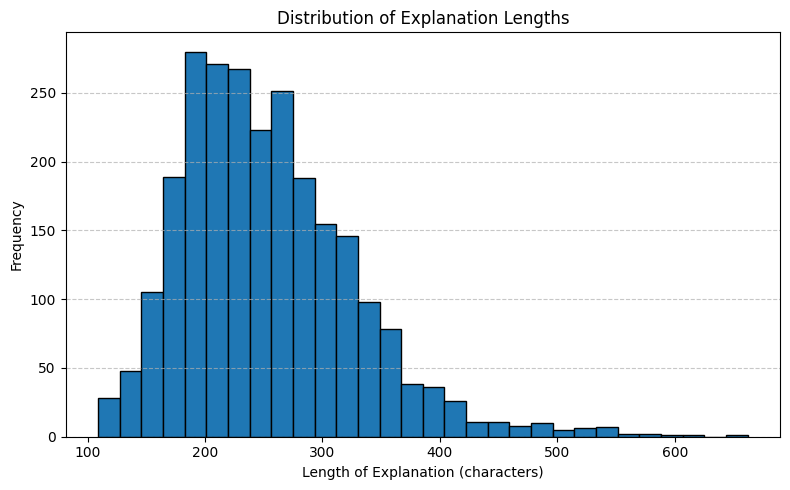

In [32]:
import matplotlib.pyplot as plt

# Ensure you have a DataFrame named 'df' with an 'explanation' column.

# 1) Calculate the length (in characters) of each explanation
lengths = deduped_df['explanation'].astype(str).str.len()

# 2) Plot histogram of these lengths
plt.figure(figsize=(8, 5))
plt.hist(lengths, bins=30, edgecolor='black')
plt.xlabel('Length of Explanation (characters)')
plt.ylabel('Frequency')
plt.title('Distribution of Explanation Lengths')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [231]:
df['exp_length'] = df['explanation'].astype(str).str.len()

# 2) Select top 5 rows by length
top5 = df.nsmallest(20, 'exp_length')

# 3) Print the explanations and their lengths
for idx, row in top5.iterrows():
    print(f"Index: {idx}  Length: {row['exp_length']}")
    print(f"Explanation:\n{row['explanation']}\n---\n")
    print(f"Question:\n{row['question']}\n---\n")

Index: 4827  Length: 81
Explanation:
To find the scaling factor, we divide the weighted average by the simple average.
---

Question:
By what factor is the weighted average of the 18-to-34 age group's survey responses scaled compared to the simple average if the simple average is 100 and the weighted average is 120?
---

Index: 632  Length: 85
Explanation:
To answer the question, we need to extract the values from the table and sum them up.
---

Question:
What is the total value of the collectibles listed in the table?
---

Index: 4866  Length: 85
Explanation:
To answer the question, we need to extract the values from the table and sum them up.
---

Question:
What is the total value of shares held by the top four mutual fund holders in Q1 2021?
---

Index: 431  Length: 92
Explanation:
To answer the question, we need to extract the transfer fees from the table and sum them up.
---

Question:
What is the total transfer fee for all the listed money transfer services?
---

Index: 599  Leng

In [200]:
#filter if answers are the same and theyre numerical
duplicates = df[df.duplicated(subset=['answer', 'txt_content'], keep=False)].reset_index(drop=True)

# 2) If you just want to see those duplicate groups:
print("Rows with matching (answer, txt_content) pairs:\n")
k = 10
print(duplicates["question"][k])
print(duplicates["answer"][k])
print(duplicates["code"][k])
print(duplicates["question"][k+1])
print(duplicates["answer"][k+1])
print(duplicates["code"][k+1])

Rows with matching (answer, txt_content) pairs:

Is the average exchange rate over the last 90 days higher than the lowest exchange rate in the last 30 days?
True
###Python
# Extract the required entities
avg_90_days = 0.3162
low_30_days = 0.3151

# Perform the comparison
ans = avg_90_days > low_30_days
###End Python
Is the difference between the 90-day high and low greater than the difference between the 30-day high and low?
True
###Python
# Extract the required values from the text
high_90 = 0.3265
low_90 = 0.3079
diff_90 = high_90 - low_90
high_30 = 0.3265
low_30 = 0.3151
diff_30 = high_30 - low_30
# Compare the differences
ans = diff_90 > diff_30
###End Python


In [26]:
 
# Sample a single random row
row = df.sample(n=1).iloc[0]

# Print the two columns
print("Question:", row["question"])
print("Explanation:", row["explanation"])
print("Code:", row["code"])
#print("Text:       ", row["txt_content"])
#print("HTML", row["text_html"])

Question: Is the average number of announcements tested per quarter in 2018 greater than 250?
Explanation: To answer the question, we need to extract the number of announcements tested for each quarter in 2018 from the provided text. We then calculate the average number of announcements tested per quarter and compare it to 250.
Code: ###Python
# Extract the number of announcements tested for each quarter in 2018
q1_2018 = 273
q2_2018 = 401
q3_2018 = 195
q4_2018 = 201
# Calculate the average number of announcements tested per quarter
avg_announcements_2018 = (q1_2018 + q2_2018 + q3_2018 + q4_2018) / 4
# Check if the average is greater than 250
ans = avg_announcements_2018 > 250
###End Python


In [37]:
mask_bool_str = deduped_df["answer"].astype(str).str.lower().isin(["true", "false"])

# 2) Count how many rows satisfy that
count_bool = mask_bool_str.sum()

print(f"Number of rows where answer is a boolean string: {count_bool}")

numeric_series = pd.to_numeric(deduped_df["answer"], errors="coerce")

# 2) Build a mask where the conversion succeeded (i.e. not NaN)
mask_numeric = numeric_series.notna()

# 3) Count how many rows are numeric
count_numeric = mask_numeric.sum()

print(f"Number of rows where answer is numeric: {count_numeric}")

Number of rows where answer is a boolean string: 879
Number of rows where answer is numeric: 1613
